In [1]:
import locale
import torch
locale.getpreferredencoding = lambda: "UTF-8"

In [2]:
!pip install onnx
!pip install onnxruntime
!pip install onnxruntime-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.2/226.2 MB 4.8 MB/s eta 0:00:00


In [3]:
def install_onnxruntime():
    if torch.cuda.is_available():
        # Install ONNX Runtime GPU version
        subprocess.check_call([sys.executable, "-m", "pip", "install", "onnxruntime-gpu"])
        print("Installed onnxruntime-gpu for GPU execution.")
    else:
        # Install ONNX Runtime CPU version
        subprocess.check_call([sys.executable, "-m", "pip", "install", "onnxruntime"])
        print("Installed onnxruntime for CPU execution.")

In [4]:
import onnxruntime as ort
import subprocess
import sys

In [5]:
install_onnxruntime()

Installed onnxruntime-gpu for GPU execution.


In [6]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import torch.nn as nn
import torch.optim as optim
from torchvision import models

import os
import time
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import onnxruntime as ort
import subprocess
import sys

# Install dataset

In [7]:
!pip install kaggle

In [8]:
# Dowload image dataset for crash detection
!kaggle datasets download -d ckay16/accident-detection-from-cctv-footage
!unzip -q 'accident-detection-from-cctv-footage.zip' -d /content/dataset

# Dowload video dataset for car crashes
!kaggle datasets download -d fahaddalwai/cctvfootagevideo
!unzip -q 'cctvfootagevideo.zip' -d /content/dataset/videos

Dataset URL: https://www.kaggle.com/datasets/ckay16/accident-detection-from-cctv-footage
License(s): ODbL-1.0
 97% 242M/249M [00:01<00:00, 158MB/s]
100% 249M/249M [00:01<00:00, 151MB/s]
Dataset URL: https://www.kaggle.com/datasets/fahaddalwai/cctvfootagevideo
License(s): CC-BY-NC-SA-4.0
 52% 5.00M/9.68M [00:00<00:00, 24.7MB/s]
100% 9.68M/9.68M [00:00<00:00, 37.7MB/s]


# Preprocessing

In [9]:
batch_size = 10
img_height = 224
img_width = 224

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),])

train_dir = '/content/dataset/data/train'
test_dir = '/content/dataset/data/test'
val_dir = '/content/dataset/data/val'

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

num_classes = len(train_dataset.classes)

In [10]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


class_names = train_dataset.classes
print("Classes:", class_names)

print(f"Train dataset: {len(train_dataset)} images")
print(f"Test dataset: {len(test_dataset)} images")
print(f"Validation dataset: {len(val_dataset)} images")

Classes: ['Accident', 'Non Accident']
Train dataset: 791 images
Test dataset: 100 images
Validation dataset: 98 images


In [11]:
for images, labels in train_loader:
    print(f"Batch image shape: {images.shape}")  # Should be [batch_size, channels, height, width]
    break

Batch image shape: torch.Size([10, 3, 224, 224])


# Model

In [12]:
# Load the pre-trained MobileNetV2 model
base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')
base_model.features = nn.Sequential(*list(base_model.features.children()))  # Extract features part of MobileNetV2
base_model.classifier = nn.Identity()  # Remove the classifier (top) part of the model

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 45.4MB/s]


In [13]:
# Freeze base model parameters
for param in base_model.parameters():
    param.requires_grad = False

In [14]:
# Define the custom model by adding a classifier on top of the base model
class CustomModel(nn.Module):
    def __init__(self, base_model, num_classes):
        super(CustomModel, self).__init__()
        self.base_model = base_model
        self.fc = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.base_model(x)
        x = self.fc(x)
        return x


In [15]:
model = CustomModel(base_model, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50

history = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}

In [16]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Training phase
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    # Append to history
    history['train_loss'].append(epoch_loss)
    history['train_accuracy'].append(epoch_acc)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_running_loss += loss.item()

    val_epoch_loss = val_running_loss / len(val_loader)
    val_epoch_acc = 100 * val_correct / val_total

    # Append to history
    history['val_loss'].append(val_epoch_loss)
    history['val_accuracy'].append(val_epoch_acc)

    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_acc:.2f}%")

Epoch [1/50], Train Loss: 0.6780, Train Accuracy: 59.80%, Val Loss: 0.5493, Val Accuracy: 71.43%
Epoch [2/50], Train Loss: 0.5724, Train Accuracy: 70.42%, Val Loss: 0.5721, Val Accuracy: 66.33%
Epoch [3/50], Train Loss: 0.6418, Train Accuracy: 67.13%, Val Loss: 0.4661, Val Accuracy: 78.57%
Epoch [4/50], Train Loss: 0.5455, Train Accuracy: 72.69%, Val Loss: 0.5594, Val Accuracy: 67.35%
Epoch [5/50], Train Loss: 0.5272, Train Accuracy: 72.69%, Val Loss: 0.5371, Val Accuracy: 76.53%
Epoch [6/50], Train Loss: 0.5101, Train Accuracy: 76.11%, Val Loss: 0.5093, Val Accuracy: 75.51%
Epoch [7/50], Train Loss: 0.4440, Train Accuracy: 80.28%, Val Loss: 0.4008, Val Accuracy: 83.67%
Epoch [8/50], Train Loss: 0.4533, Train Accuracy: 79.65%, Val Loss: 0.3906, Val Accuracy: 79.59%
Epoch [9/50], Train Loss: 0.4905, Train Accuracy: 76.36%, Val Loss: 0.3927, Val Accuracy: 81.63%
Epoch [10/50], Train Loss: 0.4500, Train Accuracy: 80.15%, Val Loss: 0.3852, Val Accuracy: 84.69%
Epoch [11/50], Train Loss: 0.

# Validation

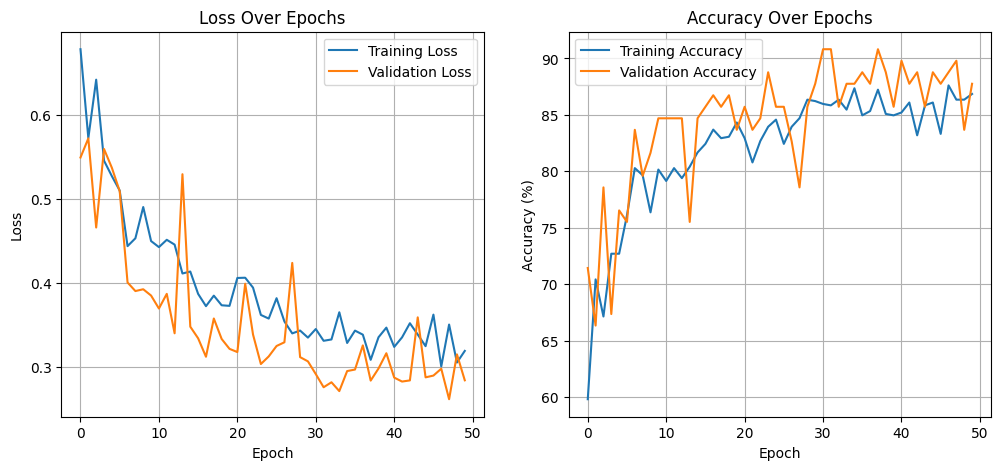

In [17]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.show()

# Dataset construction

In [18]:
model.eval()

# Transformation for input images
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
])

def process_video(video_path, model, frame_interval=1):
    # process vidoe frame by frame and predict accident
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    frame_labels = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_interval == 0:
            # Predict on the frame
            img_tensor = transform(frame).unsqueeze(0).to(device)
            with torch.no_grad():
                outputs = model(img_tensor)
                probabilities = torch.softmax(outputs, dim=1)
                predicted_class = torch.argmax(probabilities, dim=1).item()
            frame_labels.append(predicted_class)  # 0: Accident, 1: No Accident

        frame_count += 1

    cap.release()
    return frame_labels

In [19]:
def adjust_labels(frame_labels, shift=5):
    # Logic behind, shift the ‘Accident’ labels backward to preceding frames
    # As we want to identify crash before it happens
    adjusted_labels = frame_labels.copy()
    for i in range(len(frame_labels)):
        if frame_labels[i] == 0:  # Accident detected
            start = max(0, i - shift)
            for j in range(start, i):
                adjusted_labels[j] = 0  # Mark previous frames as 'Accident'
    return adjusted_labels

In [20]:
def save_sequences(video_path, adjusted_labels, sequence_length, save_dir, video_name, slide_step=10):
    """
    Organizes frames from a video into sequences and saves them along with labels.

    Parameters:
        video_path (str): Path to the input video file.
        adjusted_labels (list or array): Labels corresponding to each frame in the video.
        sequence_length (int): Number of consecutive frames in each sequence.
        save_dir (str): Directory where the sequences will be saved.
        video_name (str): Base name for the video, used in naming saved sequence files.
        slide_step (int, optional): Number of frames to move the window each step. Default is 10.
    """

    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Initialize video capture
    cap = cv2.VideoCapture(video_path)
    frames = []

    frame_count = 0
    seq_id = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # Exit the loop if no more frames are available

        frames.append(frame)
        frame_count += 1

        # Check if enough frames have been collected for a sequence
        if len(frames) == sequence_length:
            # Determine the label for the current sequence
            # Default label is 'No Accident' (1)
            seq_label = 1

            # Extract labels corresponding to the current sequence
            seq_frame_labels = adjusted_labels[frame_count - sequence_length:frame_count]

            # If any frame in the sequence has a label of '0', label the entire sequence as 'Impending Accident' (0)
            if 0 in seq_frame_labels:
                seq_label = 0

            # Convert the list of frames to a NumPy array for efficient storage
            sequence = np.array(frames)

            # Construct the filename with video name, sequence ID, and label
            seq_filename = f"{video_name}_seq_{seq_id}_label_{seq_label}.npy"

            # Save the sequence as a .npy file
            np.save(os.path.join(save_dir, seq_filename), sequence)

            # Increment the sequence ID for the next sequence
            seq_id += 1

            # Slide the window by 'slide_step' frames
            # This removes the first 'slide_step' frames from the current window
            frames = frames[slide_step:]

    # Release the video capture object
    cap.release()

### Process video together

In [21]:
video_dir = '/content/dataset/videos'
save_dir = '/content/processed_sequences'
os.makedirs(save_dir, exist_ok=True)

video_files = [f for f in os.listdir(video_dir) if f.endswith('.mp4')]

for video_file in video_files:
    video_path = os.path.join(video_dir, video_file)
    print(f"Processing {video_file}")

    # Get frame labels using the model
    frame_labels = process_video(video_path, model)

    # Adjust labels to shift 'Accident' labels backward
    adjusted_labels = adjust_labels(frame_labels, shift=5)

    # Save sequences
    save_sequences(video_path, adjusted_labels, sequence_length=16, save_dir=save_dir, video_name=video_file[:-4])

Processing videoplayback (online-video-cutter.com).mp4


In [22]:
!zip -r /content/processed_sequences.zip /content/processed_sequences

  adding: content/processed_sequences/ (stored 0%)
  adding: content/processed_sequences/videoplayback (online-video-cutter.com)_seq_7_label_0.npy (deflated 50%)
  adding: content/processed_sequences/videoplayback (online-video-cutter.com)_seq_14_label_0.npy (deflated 46%)
  adding: content/processed_sequences/videoplayback (online-video-cutter.com)_seq_189_label_1.npy (deflated 61%)
  adding: content/processed_sequences/videoplayback (online-video-cutter.com)_seq_159_label_0.npy (deflated 51%)
  adding: content/processed_sequences/videoplayback (online-video-cutter.com)_seq_9_label_0.npy (deflated 49%)
  adding: content/processed_sequences/videoplayback (online-video-cutter.com)_seq_192_label_1.npy (deflated 59%)
  adding: content/processed_sequences/videoplayback (online-video-cutter.com)_seq_170_label_0.npy (deflated 49%)
  adding: content/processed_sequences/videoplayback (online-video-cutter.com)_seq_127_label_0.npy (deflated 52%)
  adding: content/processed_sequences/videoplaybac

# Pytorch dataset construction

In [22]:
class AccidentPredictionDataset(Dataset):
    def __init__(self, sequences_dir, transform=None):
        self.transform = transform
        self.sequence_paths = []
        self.labels = []

        for filename in os.listdir(sequences_dir):
            if filename.endswith('.npy'):
                self.sequence_paths.append(os.path.join(sequences_dir, filename))
                label = int(filename.split('_label_')[1].split('.npy')[0])
                self.labels.append(label)

    def __len__(self):
        return len(self.sequence_paths)

    def __getitem__(self, idx):
        sequence = np.load(self.sequence_paths[idx])  # Shape: [seq_len, H, W, C]
        label = self.labels[idx]

        # Apply transformations to each frame
        if self.transform:
            sequence = [self.transform(frame) for frame in sequence]

        # Stack frames into a tensor
        sequence = torch.stack(sequence)  # Shape: [seq_len, C, H, W]

        return sequence, label